In [130]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import mixture
from scipy.stats import norm, multivariate_normal
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

import pylab as plt
import seaborn as sbn
from matplotlib.mlab import bivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# Normal Distribution

사람의 키, 측정치의 오류률, 혈압, 시험성적등등 많은 데이터의 유형이 gaussian distribution(normal distribution)을 따릅니다. <br>
평균값과 분산값만 알고 있다면 central theorem을 통해 분포도를 알 수 있습니다.<br>
> 데이터가 정규분포를 따를때.. <br>
> 68%는 1 std안에 존재하고, 95%는 2 std안에 존재하며, 99.7%는 3 std안에 존재합니다.

Gaussian distribution의 공식은 다음과 같으며, probability density function으로도 불립니다.<br>
PDF는 어떤 구간[a, b] 안에 확률 변수 X가 포함될 확률을 나타냅니다.

$$ \mathscr{N}(x\ |\ \mu, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} exp \left(-\frac{(x-\mu)^2}{2 \sigma^2} \right) $$


앞의 계수(coefficient) $ \frac{1}{\sqrt{2\pi \sigma^2}} $는 x에 의존하지 않는 상수로 볼 수 있습니다.<br>
따라서 일종의 normalization factor로 볼 수 있습니다.

$ -\frac{(x-\mu)^2}{2 \sigma^2} $ 이 부분이 quadratic function (2차함수) of the variable x 입니다.<br>
2차함수의 계수(the coefficient of the quadratic term)는 음수이므로 포물선(parabola)는 downwards입니다.




Text(0.5,1,'coefficient of the quadratic')

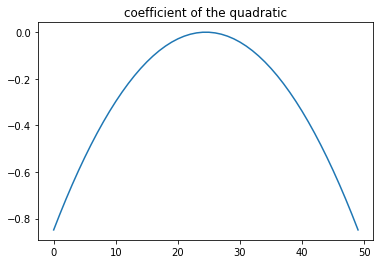

In [2]:
def downwards_parabola(x):
    mean = np.mean(x)
    std = np.std(x)
    r = -(x - mean)**2/(2*std)
    return r

x = np.linspace(-1., 1., 50)
plt.plot(downwards_parabola(x))
plt.title('coefficient of the quadratic')

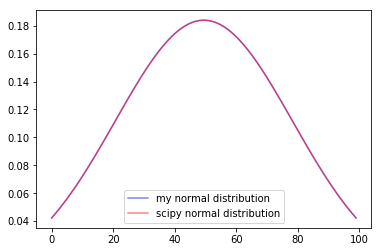

In [3]:
def normal_distribution(x):
    var = np.var(x)
    mean = np.mean(x)
    r = np.exp(-(x-mean)**2/(2*var))/ (np.sqrt(2 * np.pi * var))
    return r

def example_normal_distributions(mean):
    x = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 100) + mean
    
    plt.plot(normal_distribution(x), alpha=0.5, color='blue', label='my normal distribution')
    plt.plot(norm.pdf(x, loc=mean, scale=np.std(x)), alpha=0.5, color='red', label='scipy normal distribution')
    plt.legend()
    
example_normal_distributions(mean=15)

### Standard Normal Distribution

Normal distribution을 결정짓는 2가지 요소는 `mean` 그리고 `variance`입니다.<br>
Normal distribution과 standard normal distribution의 차이는 바로 standard normal distribution의 경우 `mean`은 9값을 갖고, `variance`는 1값을 갖습니다. <br>
(variance에다가 루트를 씌운것이 standard deviation인데.. 결국 $ \sqrt{1} = 1 $ 이므로, standard normal distribution은 std = variance = 1을 갖게 됩니다)<br>
$ X $ 라는 값이 특정 `mean` 과 `variance` 값을 가진 normal distribution일때, Z-Score를 계산함으로서 standard normal distribution으로 변환해줄 수 있습니다.

$$ Z = \frac{X -\mu}{\sigma} $$

In [4]:
def z_score(X):
    return (X - np.mean(X))/np.std(X)

x = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 1000)
z = z_score(x)

print('x mean:', np.mean(x))
print('x std :', np.std(x))
print('x variance:', np.var(x))
print('z score mean:', np.mean(z))
print('z score std :', np.std(z))
print('z score variance:', np.var(z))

x mean: 1.42108547152e-14
x std : 2.14932341883
x variance: 4.61959115873
z score mean: 0.0
z score std : 1.0
z score variance: 1.0


[random variable X]
  mean    : 15.0
  std     : 2.14932341883
  variance: 4.61959115873

[Z-score X]
  mean    : 0.0
  std     : 1.0
  variance: 1.0

MSE General  Normal Distribution: 0.0
MSE Standard Normal Distribution: 0.0


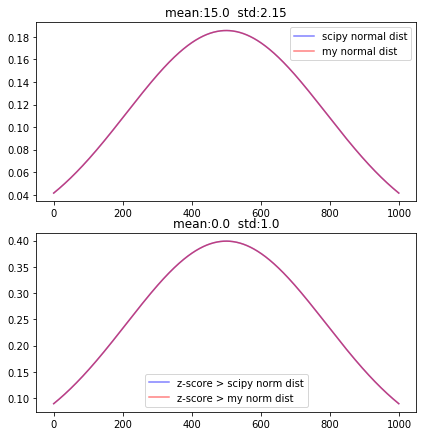

In [5]:
def example_normal_distributions(mean):
    x = np.linspace(norm.ppf(0.0001), norm.ppf(0.9999), 1000) + mean
    std = np.std(x)
    
    general_norm_data1 = norm.pdf(x, loc=mean, scale=std)
    general_norm_data2 = normal_distribution(x)

    std_norm_data1 = norm.pdf(z_score(x), loc=0, scale=1)
    std_norm_data2 = normal_distribution(z_score(x))

    fig, plots = plt.subplots(2)
    fig.set_figheight(6)
    fig.tight_layout()
    
    plots[0].plot(general_norm_data1, alpha=0.5, color='blue', label='scipy normal dist')
    plots[0].plot(general_norm_data2, alpha=0.5, color='red', label='my normal dist')
    plots[1].plot(std_norm_data1, alpha=0.5, color='blue', label='z-score > scipy norm dist')
    plots[1].plot(std_norm_data2, alpha=0.5, color='red', label='z-score > my norm dist')
    plots[0].set_title(f'mean:{round(np.mean(x),2)}  std:{round(np.std(x),2)}')
    plots[1].set_title(f'mean:{round(np.mean(z_score(x)),2)}  std:{round(np.std(z_score(x)),2)}')
    plots[0].legend()
    plots[1].legend()
    
    print('[random variable X]')
    print('  mean    :', np.mean(x))
    print('  std     :', np.std(x))
    print('  variance:', np.var(x))
    print()
    print('[Z-score X]')
    print('  mean    :', np.mean(z_score(x)))
    print('  std     :', np.std(z_score(x)))
    print('  variance:', np.var(z_score(x)))
    print()
    mse_normal = round(mean_squared_error(general_norm_data1, general_norm_data2), 12)
    mse_std_normal = round(mean_squared_error(std_norm_data1, std_norm_data2), 12)
    print(f'MSE General  Normal Distribution: {mse_normal:.12}', )
    print(f'MSE Standard Normal Distribution: {mse_std_normal:.12}')
example_normal_distributions(mean=15)

## Sampling Distribution of the Mean

어떤 분포이든지간에 표본의 평균(sample mean)은 normal distribution을 따릅니다.<br>
예를 들어서 2000명의 학생들이 종이 쪽이에 0에서 100사이의 숫자를 적은뒤 상자안에 넣습니다.<br>
수학선생님이 랜덤으로 30개의 종이쪽지를 꺼내서 평균을 냅니다. 만약 선생님이 이 작업을 여러번 할 경우<br>
표본의 평균은 확률분포는 정규분포를 갖게 됩니다.<br>
아래는 코드로 설명한 것입니다.

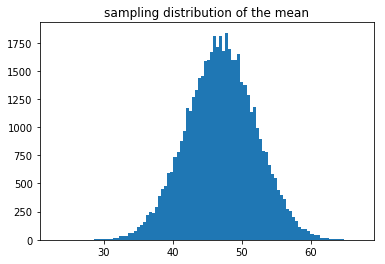

In [6]:
def test_sample_mean_is_normal_distribution(n=1000):
    X = np.random.randint(0, 100, size=2000)
    samples = np.zeros(n, dtype='float32')
    for i in range(n):
        idx = np.random.randint(0, 100, size=30)
        samples[i] = X[idx].mean()
    return samples
    
sample_means = test_sample_mean_is_normal_distribution(n=50000)
plt.hist(sample_means, bins=100)
plt.title('sampling distribution of the mean')
print()

# Multivariate Normal Distribution

한국어로 다변수 또는 다변량 정규분포라고 하며, 다차원의 공간에 확장한 분포입니다.<br>
Probability density function은 다음과 같이 정의 됩니다.


$$ p(x\ |\ \mu, \Sigma) = \frac{1}{\sqrt{ \left( 2\pi \right)^{k} \det(\Sigma)} } 
exp \left(-\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu}) \right) $$

* $ k $ : Component distribution의 갯수
* $ | \Sigma | $ : determinant of $ \Sigma $ 를 가르킵니다. 즉.. $ \det(\Sigma) $ 로 표현될수 있습니다.
* $ (\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu}) $ : Mahalanobis distance 
* $ \mu \in \mathbb{R}^n $ 이므로 각 dimension마다의 평균값을 갖은 vector라고 생각하면 됩니다.
* $ \Sigma \in \mathbb{R}^{n*n}  $ 이므로 covariance matrix는 (n, n) shape의 matrix라고 생각하면 됩니다.<br> 
   > <span style="color:#777777">Numpy의 multivariate_normal 사용시 1차원의 vector로 사용도 가능하고, 상수도 됩니다.</span>



In [348]:
data = np.array([[1, 0.1], [1.2, 3], [1.5, 10]])
pos = np.array([1, -0.1])
mean = data.mean(axis=0)
cov = np.cov(data[:, 0], data[:, 1])

print('mean:', mean)
print('cov')
print(cov)

def multivariate_gaussian_pdf(pos, mu, sigma):
    k = pos.shape[-1]
    det = np.linalg.det(sigma)
    norm = 1/np.sqrt((2*np.pi)**k * det)
    r = np.exp(-0.5 * (pos-mu)) * np.linalg.inv(sigma) * (pos - mu)
    
    print(norm * r)

print('[Scipy]')
print(multivariate_normal.pdf(pos, mean=[1, 0], cov=cov))
print()
print('[My PDF]')
multivariate_gaussian_pdf(pos, mean, cov)

mean: [ 1.23333333  4.36666667]
cov
[[  0.06333333   1.27166667]
 [  1.27166667  25.90333333]]
[Scipy]
1.02626560245

[My PDF]
[[-258.20339385  242.65337605]
 [  12.67592263  -12.08496499]]
[[ -301.83147149  2355.29638791]
 [   14.81774628  -117.30178603]]


### Example 1

아래에서는 남자와 여자의 키에 대한 multivariate normal distribution을 3d 그리고 contour 그래프로 출력해서 보여줍니다.

[Male  ] x_min: 58.4   	x_max:79.0  
[Female] y_min: 54.3   	y_max:73.4  
mean: [ 69.02634591  63.7087736 ]



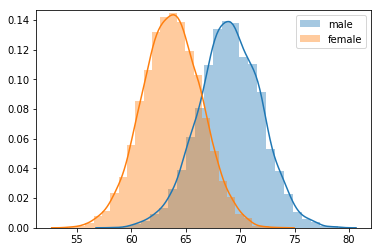

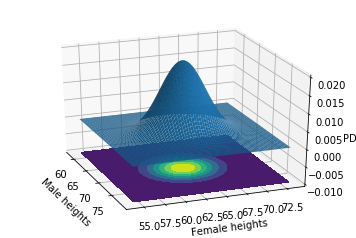

In [331]:
# Get Data
data = pd.read_csv('dataset/gender-height-weight.csv', usecols=(0, 1, 2))
# data = pd.get_dummies(data, columns=['Gender'], prefix='', prefix_sep='')

data = np.dstack([data[data['Gender'] == 'Male']['Height'], 
                  data[data['Gender'] == 'Female']['Height']])[0]


# Mean vector and covariance matrix
cov = np.cov(data[:, 0], data[:, 1])
mean = data.mean(axis=0)

# 2-dimensional distribution
x_min, x_max = data[:, 0].min(), data[:, 0].max()
y_min, y_max = data[:, 1].min(), data[:, 1].max()
x, y = np.mgrid[x_min:x_max:0.1, y_min:y_max:.1]
pos = np.dstack((x, y))

# Calculate Multivariate gausian distributions
z = multivariate_normal.pdf(pos, mean=mean, cov=cov)

# Visualization
print(f'[Male  ] x_min: {x_min:<6.3} \tx_max:{x_max:<6.3}')
print(f'[Female] y_min: {y_min:<6.3} \ty_max:{y_max:<6.3}')
print('mean:', mean)

# First Plot
sbn.distplot(data[:, 0], bins=25, label='male')
sbn.distplot(data[:, 1], bins=25, label='female')
plt.legend()

# Second 3d Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, z, rstride=3, cstride=3, linewidth=1, antialiased=True)
ax.contourf(x, y, z, zdir='z', offset=-0.01)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.01,0.02)
ax.view_init(27, -21)
ax.set_xlabel('Male heights')
ax.set_ylabel('Female heights')
ax.set_zlabel('PDF')
print()

In [ ]:
def my_multivariate_gaussian_pdf(x):
    k = x.shape[1]
    mean = x.mean(axis=0)
    cov = np.cov(x, rowvar=True)
    det = np.linalg.det(cov)
    
    print(x.shape, mean.shape, cov.shape, det, k)
    
    norm = 1/((2*np.pi)**(k) * det**(0.5))
    print('norm:', (2*np.pi)**(k))
    quad = np.exp(-1/2 * (x - mean).T @ np.linalg.inv(cov) @ (x-mean))
    return norm * quad
    
x = np.array([[1,2,3], [0,1,0]]).T

r = my_multivariate_gaussian_pdf(data)

print(r.shape, r)
sbn.distplot(r[0], label='male')
# sbn.distplot(r[1], bins=25, label='female')

## Multivariate Gaussian Visualizations

아래의 예제는 2개의 gaussian variables $ X_1 $ 그리고 $ X_2 $를 사용하는 multivariate gaussian density입니다.

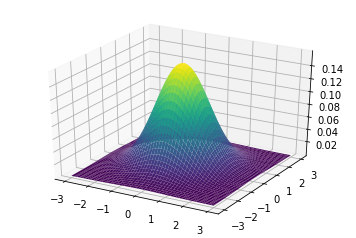

In [77]:
def example_multivariate_normal_distribution():
    x = np.linspace(-3, 3, 1000)
    y = np.linspace(-3, 3, 1000)
    x, y = np.meshgrid(x, y)
    z = bivariate_normal(x, y)
  
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis')
    
example_multivariate_normal_distribution()

아래는 contour로 multivariate gaussian distribution을 타나냈습니다.<br>
예제의 Covariance matrix값이 [[1, 0], [0, 1]] 이므로, Identity matrix입니다.

중앙 밝은색일수록 확률이 더 높다는 뜻입니다.<br>
Convariance matrix값이 커질수록 범위가 더 커집니다.

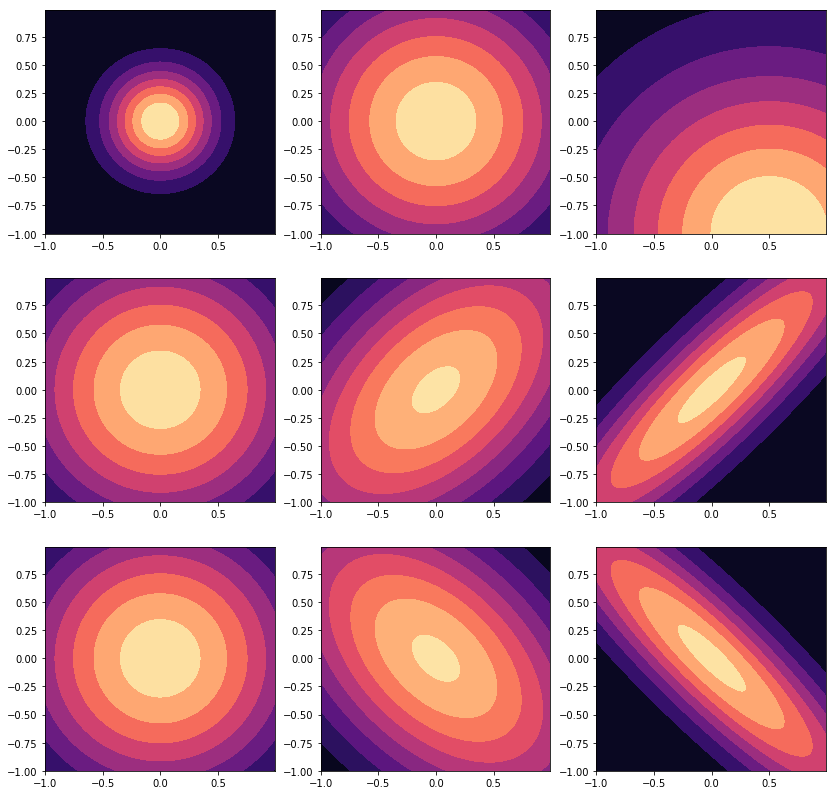

In [76]:
def example_multivariate_normal_distribution2():
    x, y = np.mgrid[-1:1:0.01, -1:1:.01]
    pos = np.dstack((x, y))
    
    rv1 = multivariate_normal(mean=[0, 0], cov=[[0.1, 0],[0, 0.1]])
    rv2 = multivariate_normal(mean=[0, 0], cov=[[1, 0],[0, 1]])
    rv3 = multivariate_normal(mean=[0.5, -1], cov=[[1, 0],[0, 1]])
    
    rv4 = multivariate_normal(mean=[0, 0], cov=[[1, 0],[0, 1]])
    rv5 = multivariate_normal(mean=[0, 0], cov=[[1, 0.5],[0.5, 1]])
    rv6 = multivariate_normal(mean=[0, 0], cov=[[1, 0.9],[0.9, 1]])
    
    rv7 = multivariate_normal(mean=[0, 0], cov=[[1, 0],[0, 1]])
    rv8 = multivariate_normal(mean=[0, 0], cov=[[1, -0.5],[-0.5, 1]])
    rv9 = multivariate_normal(mean=[0, 0], cov=[[1, -0.9],[-0.9, 1]])
    
    fig, subplots = plt.subplots(3, 3)
    fig.set_figwidth(14)
    fig.set_figheight(14)
    subplots = subplots.reshape(-1)
    
    subplots[0].contourf(x, y, rv1.pdf(pos), cmap='magma')
    subplots[1].contourf(x, y, rv2.pdf(pos), cmap='magma')
    subplots[2].contourf(x, y, rv3.pdf(pos), cmap='magma')
    
    subplots[3].contourf(x, y, rv4.pdf(pos), cmap='magma')
    subplots[4].contourf(x, y, rv5.pdf(pos), cmap='magma')
    subplots[5].contourf(x, y, rv6.pdf(pos), cmap='magma')
    
    subplots[6].contourf(x, y, rv7.pdf(pos), cmap='magma')
    subplots[7].contourf(x, y, rv8.pdf(pos), cmap='magma')
    subplots[8].contourf(x, y, rv9.pdf(pos), cmap='magma')
    
    
example_multivariate_normal_distribution2()

## Scipy Multivariate Normal Distribution

Mean은 N-dimensional space의 좌표이며 표본데이터가 가장 많이 나타낼 위치입니다. <br>
따라서 일반적인 univariate normal distribution의 peak 부분의 위치와 동일하다고 볼수 있습니다. 

Covariance는 2개의 분포가 서로 유사하게 움직이는지 판단하는데 사용됩니다.<br>
예를 들어 positive covariance는 서로 동일하게 움직인다는 뜻이며 (증가하거나 감소하거나) <br>
Negative covariance의 경우는 서로 반대방향으로 움직이고 있다는 뜻입니다. 

Scipy사용시 full covariance matrix를 사용하지 않고 approximation을 사용합니다.

* Spherical covariance
* Diagonal covariance

In [ ]:
def example_scipy_multivariate_norm():
    mean = [10, 0]
    cov = [[25, 7], [0, -2]]
    multi_norms = np.random.multivariate_normal(mean, cov, 5000)
    x = multi_norms[:, 0]
    y = multi_norms[:, 1]
    plt.scatter(x, y)
    plt.xlabel('x mean=10')
    plt.ylabel('y mean=0')
    plt.axis('equal')

example_scipy_multivariate_norm()